In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import os
import random
from torch.autograd import Variable
import copy
from torch import nn, optim
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import csv
import time
import math

In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
fix_seed(SEED)

In [3]:
class Argments():
  def __init__(self):
    self.batch_size = 40
    self.test_batch = 1000
    self.global_epochs = 500
    self.local_epochs = 2
    self.lr = None
    self.momentum = 0.9
    self.weight_decay = 10**-4.0
    self.clip = 20.0
    self.partience = 500
    self.worker_num = 20
    self.sample_num = 20
    self.unlabeleddata_size = 1000
    self.device = torch.device('cuda:0'if torch.cuda.is_available() else'cpu')
    self.criterion_ce = nn.CrossEntropyLoss()
    self.criterion_kl = nn.KLDivLoss(reduction='batchmean')
    
    self.alpha_label = 0.5
    self.alpha_size = 10

args = Argments()

In [4]:
# Tuned value
lr = 2

In [6]:
lr_list = []
lr_list.append(10**-3.0)
lr_list.append(10**-2.5)
lr_list.append(10**-2.0)
lr_list.append(10**-1.5)
lr_list.append(10**-1.0)
lr_list.append(10**-0.5)
lr_list.append(10**0.0)
lr_list.append(10**0.5)

args.lr = lr_list[lr]

In [9]:
class LocalDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.data = []
        self.label = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]
        if self.transform:
            out_data = self.transform(out_data)
        return out_data, out_label
    
class DatasetFromSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
class GlobalDataset(torch.utils.data.Dataset):
  def __init__(self,federated_dataset,transform=None):
    self.transform = transform
    self.data = []
    self.label = []
    for dataset in federated_dataset:
      for (data,label) in dataset:
        self.data.append(data)
        self.label.append(label)

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = self.label[idx]
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

class UnlabeledDataset(torch.utils.data.Dataset):
  def __init__(self,transform=None):
    self.transform = transform
    self.data = []
    self.target = None

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = 'unlabeled'
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

In [10]:
def get_dataset(Centralized=False,unlabeled_data=False):
    
    transform_train = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomCrop(32, padding=2),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])
    transform_test = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])

    # download train data
    all_trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
    #trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

    # download test data
    all_testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True)
    #testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

    
    ## get unlabeled dataset
    if unlabeled_data:
        unlabeled_dataset = UnlabeledDataset(transform_test)
        idx = sorted(random.sample(range(len(all_trainset)),args.unlabeleddata_size))
        unlabeled_dataset.data = np.array([all_trainset.data[i]  for i in idx])
        all_trainset.data = np.delete(all_trainset.data,idx,0)
        all_trainset.targets = np.delete(all_trainset.targets,idx,0)
    all_train_data = np.array(all_trainset.data)
    all_train_label = np.array(all_trainset.targets)
    all_test_data = np.array(all_testset.data)
    all_test_label = np.array(all_testset.targets)
    print('Train:{} Test:{}'.format(len(all_train_data),len(all_test_data)))


    ## Data size heterogeneity
    data_proportions = np.random.dirichlet(np.repeat(args.alpha_size, args.worker_num))
    train_data_proportions = np.array([0 for _ in range(args.worker_num)])
    test_data_proportions = np.array([0 for _ in range(args.worker_num)])
    for i in range(len(data_proportions)):
        if i==(len(data_proportions)-1):
            train_data_proportions = train_data_proportions.astype('int64')
            test_data_proportions = test_data_proportions.astype('int64')
            train_data_proportions[-1] = len(all_train_data) - np.sum(train_data_proportions[:-1])
            test_data_proportions[-1] = len(all_test_data) - np.sum(test_data_proportions[:-1])
        else:
            train_data_proportions[i] = (data_proportions[i] * len(all_train_data))
            test_data_proportions[i] = (data_proportions[i] * len(all_test_data))
    min_size = 0
    K = 10

    '''
    label_list = np.arange(10)
    np.random.shuffle(label_list)
    '''
    label_list = list(range(K))


    ## Data distribution heterogeneity
    while min_size<10:
        idx_train_batch = [[] for _ in range(args.worker_num)]
        idx_test_batch = [[] for _ in range(args.worker_num)]
        for k in label_list:
            proportions_train = np.random.dirichlet(np.repeat(args.alpha_label, args.worker_num))
            proportions_test = copy.deepcopy(proportions_train)
            idx_k_train = np.where(all_train_label == k)[0]
            idx_k_test = np.where(all_test_label == k)[0]
            np.random.shuffle(idx_k_train)
            np.random.shuffle(idx_k_test)
            ## Balance (train)
            proportions_train = np.array([p*(len(idx_j)<train_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_train,idx_train_batch))])
            proportions_train = proportions_train/proportions_train.sum()
            proportions_train = (np.cumsum(proportions_train)*len(idx_k_train)).astype(int)[:-1]
            idx_train_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_train_batch,np.split(idx_k_train,proportions_train))]

            ## Balance (test)
            proportions_test = np.array([p*(len(idx_j)<test_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_test,idx_test_batch))])
            proportions_test = proportions_test/proportions_test.sum()
            proportions_test = (np.cumsum(proportions_test)*len(idx_k_test)).astype(int)[:-1]
            idx_test_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_test_batch,np.split(idx_k_test,proportions_test))]

            min_size = min([len(idx_j) for idx_j in idx_train_batch])

    federated_trainset = []
    federated_testset = []
    for i in range(args.worker_num):
        ## create trainset
        data = [all_train_data[idx] for idx in idx_train_batch[i]]
        label = [all_train_label[idx] for idx in idx_train_batch[i]]
        federated_trainset.append(LocalDataset())
        federated_trainset[-1].data = data
        federated_trainset[-1].label = label

        ## create testset
        data = [all_test_data[idx] for idx in idx_test_batch[i]]
        label = [all_test_label[idx] for idx in idx_test_batch[i]]
        federated_testset.append(LocalDataset())
        federated_testset[-1].data = data
        federated_testset[-1].label = label

        
    ## split trainset
    federated_valset = [None]*args.worker_num
    for i in range(args.worker_num):
        n_samples = len(federated_trainset[i])
        if n_samples==1:
            train_subset = federated_trainset[i]
            val_subset = copy.deepcopy(federated_trainset[i])
        else:
            train_size = int(len(federated_trainset[i]) * 0.8) 
            val_size = n_samples - train_size 
            train_subset,val_subset = torch.utils.data.random_split(federated_trainset[i], [train_size, val_size])

        federated_trainset[i] = DatasetFromSubset(train_subset)
        federated_valset[i] = DatasetFromSubset(val_subset)

    ## show data distribution
    H = 4
    W = 5
    fig, axs = plt.subplots(H, W, figsize=(20, 5))
    x = np.arange(1,11)
    for i, (trainset,valset,testset) in enumerate(zip(federated_trainset,federated_valset,federated_testset)):
        bottom = [0]*10
        count = [0]*10
        for _,label in trainset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in valset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in testset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        #axs[int(i/W), i%W].title("worker{}".format(i+1), fontsize=12, color = "green")

    plt.show()

    ## get global dataset
    if Centralized:
        global_trainset = GlobalDataset(federated_trainset)
        global_valset = GlobalDataset(federated_valset)
        global_testset =  GlobalDataset(federated_testset)
        
        #show_cifer(global_trainset.data,global_testset.label, cifar10_labels)

        global_trainset.transform = transform_train
        global_valset.transform = transform_test
        global_testset.transform = transform_test

        global_trainloader = torch.utils.data.DataLoader(global_trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
        global_valloader = torch.utils.data.DataLoader(global_valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
        global_testloader = torch.utils.data.DataLoader(global_testset,batch_size=args.test_batch,shuffle=False,num_workers=2)

    ## set transform
    for i in range(args.worker_num):
        federated_trainset[i].transform = transform_train
        federated_valset[i].transform = transform_test
        federated_testset[i].transform = transform_test
    
    if Centralized and unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader,unlabeled_dataset
    if Centralized:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader
    elif unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,unlabeled_dataset
    else:
        return federated_trainset,federated_valset,federated_testset

Files already downloaded and verified
Files already downloaded and verified
Train:49000 Test:10000


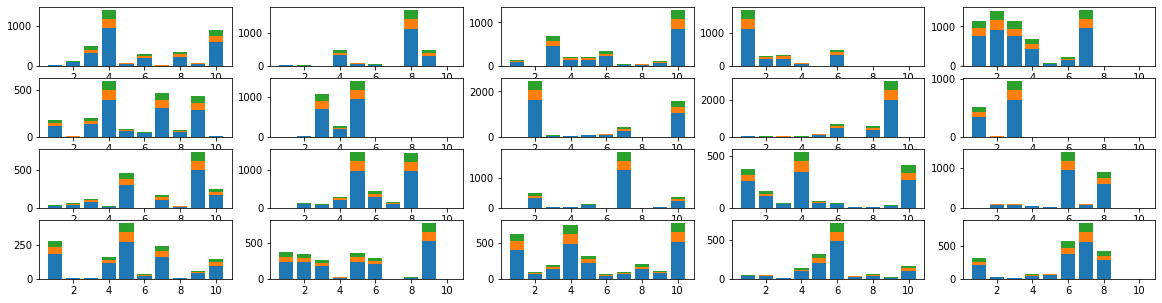

In [11]:
federated_trainset,federated_valset,federated_testset,unlabeled_dataset = get_dataset(unlabeled_data=True)

In [12]:
total = [0,0,0]
for i in range(args.worker_num):
    total[0]+=len(federated_trainset[i])
    total[1]+=len(federated_valset[i])
    total[2]+=len(federated_testset[i])
print(total)

[39191, 9809, 10000]


In [14]:
class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            #print("in_channels: {}, v: {}".format(in_channels, v))
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


class VGGConvBlocks(nn.Module):
    '''
    VGG containers that only contains the conv layers 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

class VGGContainer(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, input_dim, hidden_dims, num_classes=10):
        super(VGGContainer, self).__init__()
        self.features = features
        # note: we hard coded here a bit by assuming we only have two hidden layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(True),
            nn.Linear(hidden_dims[1], num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def matched_vgg11(matched_shapes):
    # [(67, 27), (67,), (132, 603), (132,), (260, 1188), (260,), (261, 2340), (261,), (516, 2349), (516,), (517, 4644), (517,), 
    # (516, 4653), (516,), (516, 4644), (516,), (516, 515), (515,), (515, 515), (515,), (515, 10), (10,)]
    processed_matched_shape = [matched_shapes[0][0], 
                                'M', 
                                matched_shapes[2][0], 
                                'M', 
                                matched_shapes[4][0], 
                                matched_shapes[6][0], 
                                'M', 
                                matched_shapes[8][0], 
                                matched_shapes[10][0], 
                                'M', 
                                matched_shapes[12][0], 
                                matched_shapes[14][0], 
                                'M']
    return VGGContainer(make_layers(processed_matched_shape), input_dim=matched_shapes[16][0], 
            hidden_dims=[matched_shapes[16][1], matched_shapes[18][1]], num_classes=10)


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn(num_classes=10):
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True), num_classes=num_classes)


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [15]:
class Server():
  def __init__(self):
    self.global_model = vgg13()

  def create_worker(self,federated_trainset,federated_valset,federated_testset):
    workers = []
    for i in range(args.worker_num):
      workers.append(Worker(federated_trainset[i],federated_valset[i],federated_testset[i]))
    return workers

  def sample_worker(self,workers):
    sample_worker = []
    sample_worker_num = random.sample(range(args.worker_num),args.sample_num)
    for i in sample_worker_num:
      sample_worker.append(workers[i])
    return sample_worker


  def send_model(self,workers):
    nums = 0
    for worker in workers:
      nums += worker.train_data_num

    for worker in workers:
      worker.aggregation_weight = 1.0*worker.train_data_num/nums
      worker.global_model = copy.deepcopy(self.global_model)

  def aggregate_model(self,workers):   
    new_params = OrderedDict()
    for i,worker in enumerate(workers):
      worker_state = worker.global_model.state_dict()
      for key in worker_state.keys():
        if i==0:
          new_params[key] = worker_state[key]*worker.aggregation_weight
        else:
          new_params[key] += worker_state[key]*worker.aggregation_weight
      worker.global_model = worker.global_model.to('cpu')
      del worker.global_model
    self.global_model.load_state_dict(new_params)

In [16]:
class Worker():
  def __init__(self,trainset,valset,testset):
    self.trainloader = torch.utils.data.DataLoader(trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
    self.valloader = torch.utils.data.DataLoader(valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    self.testloader = torch.utils.data.DataLoader(testset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    self.local_model = vgg13()
    self.global_model = None
    self.train_data_num = len(trainset)
    self.test_data_num = len(testset)
    self.aggregation_weight = None

  def local_train(self):
    self.local_model = self.local_model.to(args.device)
    self.global_model = self.global_model.to(args.device)
    local_optimizer = optim.SGD(self.local_model.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
    global_optimizer = optim.SGD(self.global_model.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
    self.local_model.train()
    self.global_model.train()
    for epoch in range(args.local_epochs):
      running_loss = 0.0
      correct = 0
      count = 0
      for (data,labels) in self.trainloader:
        data,labels = Variable(data),Variable(labels)
        data,labels = data.to(args.device),labels.to(args.device)
        local_optimizer.zero_grad()
        global_optimizer.zero_grad()
        local_outputs = self.local_model(data)
        global_outputs = self.global_model(data)
        #train local_model
        ce_loss = args.criterion_ce(local_outputs,labels)
        kl_loss = args.criterion_kl(F.log_softmax(local_outputs, dim = 1),F.softmax(Variable(global_outputs), dim=1))
        loss = ce_loss + kl_loss
        running_loss += loss.item()
        predicted = torch.argmax(local_outputs,dim=1)
        correct += (predicted==labels).sum().item()
        count += len(labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.local_model.parameters(), args.clip)
        local_optimizer.step()

        #train global_model
        ce_loss = args.criterion_ce(global_outputs,labels)
        kl_loss = args.criterion_kl(F.log_softmax(global_outputs, dim = 1),F.softmax(Variable(local_outputs), dim=1))
        loss = ce_loss + kl_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.global_model.parameters(), args.clip)
        global_optimizer.step()
        
    return 100.0*correct/count,running_loss/len(self.trainloader)


  def validate(self):
    acc,loss = test(self.local_model,args.criterion_ce,self.valloader)
    self.local_model = self.local_model.to('cpu')
    return acc,loss

In [17]:
def train(model,criterion,trainloader,epochs):
  optimizer = optim.SGD(model.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    count = 0
    for (data,labels) in trainloader:
      data,labels = Variable(data),Variable(labels)
      data,labels = data.to(args.device),labels.to(args.device)
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs,labels)
      running_loss += loss.item()
      predicted = torch.argmax(outputs,dim=1)
      correct += (predicted==labels).sum().item()
      count += len(labels)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
      optimizer.step()

  return 100.0*correct/count,running_loss/len(trainloader)



In [18]:
def test(model,criterion,testloader):
  model.eval()
  running_loss = 0.0
  correct = 0
  count = 0
  for (data,labels) in testloader:
    data,labels = data.to(args.device),labels.to(args.device)
    outputs = model(data)
    running_loss += criterion(outputs,labels).item()
    predicted = torch.argmax(outputs,dim=1)
    correct += (predicted==labels).sum().item()
    count += len(labels)

  accuracy = 100.0*correct/count
  loss = running_loss/len(testloader)


  return accuracy,loss

In [19]:
class Early_Stopping():
  def __init__(self,partience):
    self.step = 0
    self.loss = float('inf')
    self.partience = partience

  def validate(self,loss):
    if self.loss<loss:
      self.step += 1
      if self.step>self.partience:
        return True
    else:
      self.step = 0
      self.loss = loss

    return False

In [20]:
server = Server()
workers = server.create_worker(federated_trainset,federated_valset,federated_testset)
acc_train = []
loss_train = []
acc_valid = []
loss_valid = []

early_stopping = Early_Stopping(args.partience)

start = time.time()

for epoch in range(args.global_epochs):
  sample_worker = server.sample_worker(workers)
  server.send_model(sample_worker)

  acc_train_avg = 0.0
  loss_train_avg = 0.0
  acc_valid_avg = 0.0
  loss_valid_avg = 0.0
  for worker in sample_worker:
    acc_train_tmp,loss_train_tmp = worker.local_train()
    acc_valid_tmp,loss_valid_tmp = worker.validate()
    acc_train_avg += acc_train_tmp/len(sample_worker)
    loss_train_avg += loss_train_tmp/len(sample_worker)
    acc_valid_avg += acc_valid_tmp/len(sample_worker)
    loss_valid_avg += loss_valid_tmp/len(sample_worker)
  server.aggregate_model(sample_worker)
  '''
  server.model.to(args.device)
  for worker in workers:
    acc_valid_tmp,loss_valid_tmp = test(server.model,args.criterion,worker.valloader)
    acc_valid_avg += acc_valid_tmp/len(workers)
    loss_valid_avg += loss_valid_tmp/len(workers)
  server.model.to('cpu')
  '''
  print('Epoch{}  loss:{}  accuracy:{}'.format(epoch+1,loss_valid_avg,acc_valid_avg))
  acc_train.append(acc_train_avg)
  loss_train.append(loss_train_avg)
  acc_valid.append(acc_valid_avg)
  loss_valid.append(loss_valid_avg)

  if early_stopping.validate(loss_valid_avg):
    print('Early Stop')
    break
    
end = time.time()

Epoch1  loss:1.663982126116753  accuracy:43.71685200903926
Epoch2  loss:1.4982869386672975  accuracy:43.56939597543205
Epoch3  loss:1.474682769179344  accuracy:44.5067976409522
Epoch4  loss:1.463369381427765  accuracy:43.98918840214481
Epoch5  loss:1.4534801065921785  accuracy:45.08686388517641
Epoch6  loss:1.446540766954422  accuracy:44.51164369180111
Epoch7  loss:1.434243494272232  accuracy:45.26356433297916
Epoch8  loss:1.4249505430459979  accuracy:45.972269987647685
Epoch9  loss:1.410945948958397  accuracy:46.459381670690256
Epoch10  loss:1.3907708138227461  accuracy:48.61095370890093
Epoch11  loss:1.3640322029590608  accuracy:49.20251333031607
Epoch12  loss:1.345792070031166  accuracy:50.354387049467036
Epoch13  loss:1.3243111461400987  accuracy:51.66106743948682
Epoch14  loss:1.2922062665224074  accuracy:53.076986897531384
Epoch15  loss:1.2725894957780837  accuracy:53.975705415359926
Epoch16  loss:1.2661075443029406  accuracy:54.414367448550045
Epoch17  loss:1.2484104633331299  a

Epoch136  loss:0.6995026104152203  accuracy:76.45261898658674
Epoch137  loss:0.6803780611604451  accuracy:77.10611633157826
Epoch138  loss:0.6867974705994128  accuracy:76.7675607500402
Epoch139  loss:0.6802399717271328  accuracy:77.25273027695472
Epoch140  loss:0.6825607255101204  accuracy:77.06867317335826
Epoch141  loss:0.6755380153656005  accuracy:77.16969668463794
Epoch142  loss:0.6779172644019127  accuracy:77.21270491915462
Epoch143  loss:0.6757138526067139  accuracy:77.1155323870205
Epoch144  loss:0.667306899279356  accuracy:77.7483710035051
Epoch145  loss:0.6699051443487406  accuracy:77.30823268467864
Epoch146  loss:0.6741863116621971  accuracy:77.36750239560214
Epoch147  loss:0.6657050311565398  accuracy:77.57076891548009
Epoch148  loss:0.6671045184135436  accuracy:77.74593341891038
Epoch149  loss:0.6634644269943236  accuracy:77.69886105592079
Epoch150  loss:0.6770287394523622  accuracy:77.12691438807857
Epoch151  loss:0.6662525467574596  accuracy:77.69629258396513
Epoch152  lo

Epoch269  loss:0.6529439810197799  accuracy:79.44742718535917
Epoch270  loss:0.6464462715201079  accuracy:79.46517886504544
Epoch271  loss:0.6514387242030352  accuracy:79.28884766614286
Epoch272  loss:0.6464096246287228  accuracy:79.30605825423179
Epoch273  loss:0.6571569133549928  accuracy:78.98886391420623
Epoch274  loss:0.6439578797202556  accuracy:79.95137626993218
Epoch275  loss:0.6512431782204658  accuracy:79.18931246451655
Epoch276  loss:0.65772994607687  accuracy:79.23738174598019
Epoch277  loss:0.6561937740072608  accuracy:79.27716997183869
Epoch278  loss:0.6567149654962123  accuracy:78.87880596123019
Epoch279  loss:0.6529754977673291  accuracy:79.90315859255556
Epoch280  loss:0.6553349625086412  accuracy:79.30753958932955
Epoch281  loss:0.6593528794590384  accuracy:79.17194618181881
Epoch282  loss:0.6569015063345433  accuracy:79.22931014360798
Epoch283  loss:0.6523304757196455  accuracy:79.52689425357498
Epoch284  loss:0.6560969168320298  accuracy:79.40473253880573
Epoch285  

Epoch402  loss:0.7146137198084034  accuracy:79.54645850964405
Epoch403  loss:0.7148583146627062  accuracy:79.28410145719045
Epoch404  loss:0.7248706777201733  accuracy:79.39709606652394
Epoch405  loss:0.7159262916829903  accuracy:79.51002636746585
Epoch406  loss:0.7240250683098566  accuracy:79.23846826856143
Epoch407  loss:0.7229719304596073  accuracy:79.43542975164016
Epoch408  loss:0.724940707033966  accuracy:79.27602527349387
Epoch409  loss:0.7254998823511414  accuracy:79.47866464504058
Epoch410  loss:0.7329430838493863  accuracy:79.13450351614786
Epoch411  loss:0.7325914091721643  accuracy:79.59873501974214
Epoch412  loss:0.7407091720102471  accuracy:79.53578168712889
Epoch413  loss:0.7246176148357335  accuracy:79.68200268092941
Epoch414  loss:0.730041321471799  accuracy:79.63325706344283
Epoch415  loss:0.7377906578942202  accuracy:79.279193859009
Epoch416  loss:0.7189221077773255  accuracy:79.63700061112779
Epoch417  loss:0.7338810355635359  accuracy:79.62754906300745
Epoch418  lo

In [22]:
acc_test = []
loss_test = []

start = time.time()

for i,worker in enumerate(workers):
  worker.global_model = copy.deepcopy(server.global_model)
  _,_ = worker.local_train()
  acc_tmp,loss_tmp = test(worker.local_model,args.criterion_ce,worker.testloader)
  acc_test.append(acc_tmp)
  loss_test.append(loss_tmp)
  print('Worker{} accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))
  worker.local_model = worker.local_model.to('cpu')
  worker.global_model = worker.global_model.to('cpu')
  del worker.global_model

end = time.time()

acc_test_avg = sum(acc_test)/len(acc_test)
loss_test_avg = sum(loss_test)/len(loss_test)
print('Test  loss:{}  accuracy:{}'.format(loss_test_avg,acc_test_avg))

Worker1 accuracy:73.57910906298002  loss:1.2372404336929321
Worker2 accuracy:86.27049180327869  loss:0.5966750383377075
Worker3 accuracy:72.38095238095238  loss:1.1705563068389893
Worker4 accuracy:82.73809523809524  loss:0.6692302823066711
Worker5 accuracy:82.2439024390244  loss:0.4627133049070835
Worker6 accuracy:68.24512534818942  loss:1.1762255430221558
Worker7 accuracy:80.84210526315789  loss:0.7236917018890381
Worker8 accuracy:88.55054811205846  loss:0.5238895416259766
Worker9 accuracy:88.6624203821656  loss:0.5901362299919128
Worker10 accuracy:85.31746031746032  loss:0.44625425338745117
Worker11 accuracy:77.14285714285714  loss:0.9603099822998047
Worker12 accuracy:77.84172661870504  loss:1.0478436946868896
Worker13 accuracy:89.79591836734694  loss:0.5337216258049011
Worker14 accuracy:75.51724137931035  loss:0.996197521686554
Worker15 accuracy:79.95642701525054  loss:0.941811203956604
Worker16 accuracy:65.06550218340611  loss:1.2389367818832397
Worker17 accuracy:76.41509433962264 